In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [4]:
rng = np.random.RandomState(42)

In [46]:
n_samples = int(1e4)
n_signal_samples = int(0.9 * n_samples)
n_noise_samples = n_samples - n_signal_samples
n_features = 100

signal, labels = make_blobs(n_samples=n_signal_samples, n_features=n_features,
                            cluster_std=1, centers=500,
                            random_state=rng)
noise = rng.uniform(low=-15, high=15, size=(n_noise_samples, n_features))

data = np.vstack([signal, noise])
labels = np.concatenate([labels, [-1] * noise.shape[0]])
data, labels = shuffle(data, labels, random_state=rng)

In [47]:
def plot_data_with_labels(data, labels, alpha=0.3, cm=plt.cm.prism, subsample=int(5e4),
                          random_state=0):
    n_samples = data.shape[0]
    title = "Scatter plot of the first 2 dimensions"
    if n_samples > subsample:
        idx = shuffle(np.arange(n_samples), random_state=random_state)[:subsample]
        data = data[idx]
        labels = labels[idx]
        title += "\nssubsampled to %d samples out of %d" % (subsample, n_samples)

    plt.figure(figsize=(10, 10))
    plt.xlim(-12, 12)
    plt.ylim(-12, 12)

    unique_labels = np.unique(labels)
    colors = cm(np.linspace(0, 1, len(unique_labels)))
    for l, c in zip(unique_labels, colors):
        if l == -1:
            c = 'b'
        data_l = data[labels == l]
        plt.scatter(data_l[:, 0], data_l[:, 1], alpha=alpha,
                    facecolors=c, edgecolors='none')
    plt.title(title)

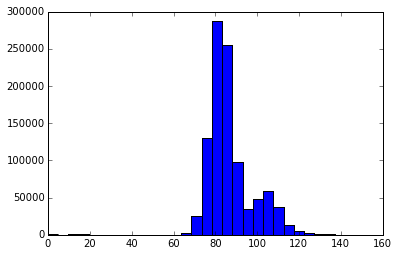

In [48]:
from sklearn.metrics import euclidean_distances

plt.hist(euclidean_distances(data[:100], 
                            ).ravel(), bins=30);

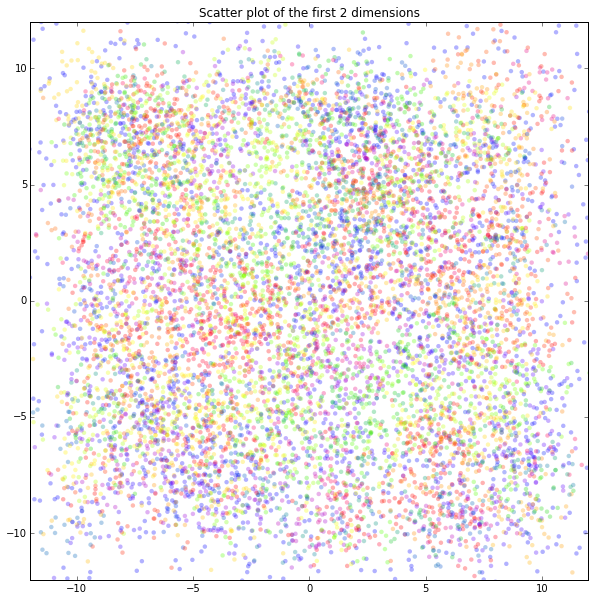

In [49]:
plot_data_with_labels(data, labels)

## DBSCAN

In [60]:
%%time
from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=0.05, algorithm='kd_tree')
dbscan = DBSCAN(eps=30, algorithm='kd_tree')
dbscan_labels = dbscan.fit_predict(data)

CPU times: user 52.6 s, sys: 242 ms, total: 52.9 s
Wall time: 53.1 s


In [61]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("NMI DBSCAN: %0.3f"
      % normalized_mutual_info_score(labels, dbscan_labels))
print("ARI DBSCAN: %0.3f"
      % adjusted_rand_score(labels, dbscan_labels))

NMI DBSCAN: 1.000
ARI DBSCAN: 1.000


In [62]:
unique_dbscan_labels = np.unique(dbscan_labels)
print(len(unique_dbscan_labels))

501


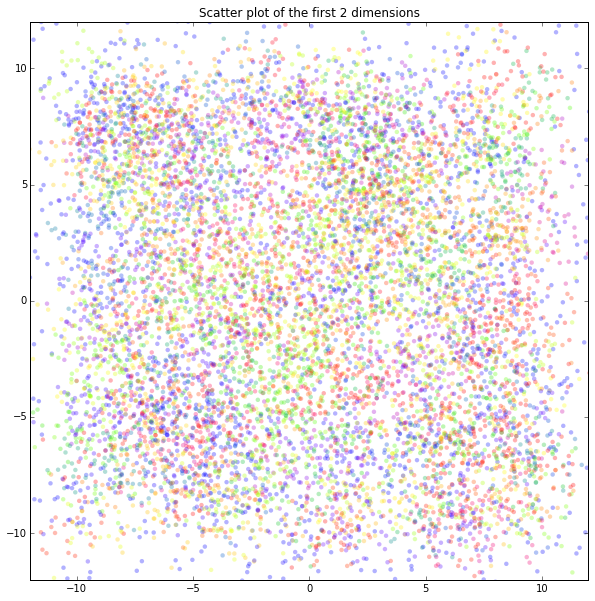

In [63]:
plot_data_with_labels(data, dbscan_labels)

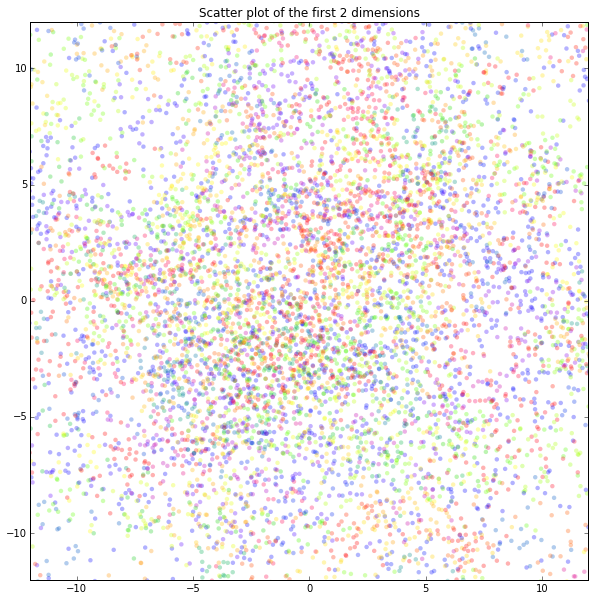

In [64]:
from sklearn.decomposition import RandomizedPCA

data_pca = RandomizedPCA(n_components=10).fit_transform(data)
plot_data_with_labels(data_pca, labels)

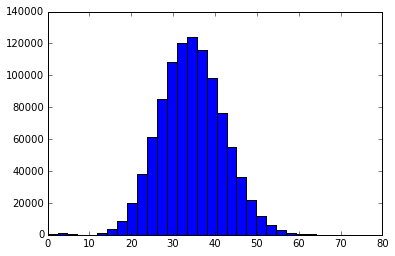

In [65]:
plt.hist(euclidean_distances(data_pca[:100], data_pca).ravel(), bins=30);

In [68]:
%%time
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=7, algorithm='kd_tree')
dbscan_labels = dbscan.fit_predict(data_pca)

CPU times: user 1 s, sys: 29.8 ms, total: 1.03 s
Wall time: 1.03 s


In [69]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("NMI DBSCAN: %0.3f"
      % normalized_mutual_info_score(labels, dbscan_labels))
print("ARI DBSCAN: %0.3f"
      % adjusted_rand_score(labels, dbscan_labels))

NMI DBSCAN: 0.998
ARI DBSCAN: 0.996


##  Mini Batch K-Means

In [10]:
%%time
from sklearn.cluster import MiniBatchKMeans

mbkmeans = MiniBatchKMeans(n_clusters=500, init_size=int(1e4), batch_size=int(1e3))
mbkmeans_labels = mbkmeans.fit_predict(data)

CPU times: user 3.54 s, sys: 264 ms, total: 3.8 s
Wall time: 3.55 s


In [11]:
print("NMI MB K-Means: %0.3f"
      % normalized_mutual_info_score(labels, mbkmeans_labels))
print("ARI MB K-Means: %0.3f"
      % adjusted_rand_score(labels, mbkmeans_labels))

NMI MB K-Means: 0.897
ARI MB K-Means: 0.245


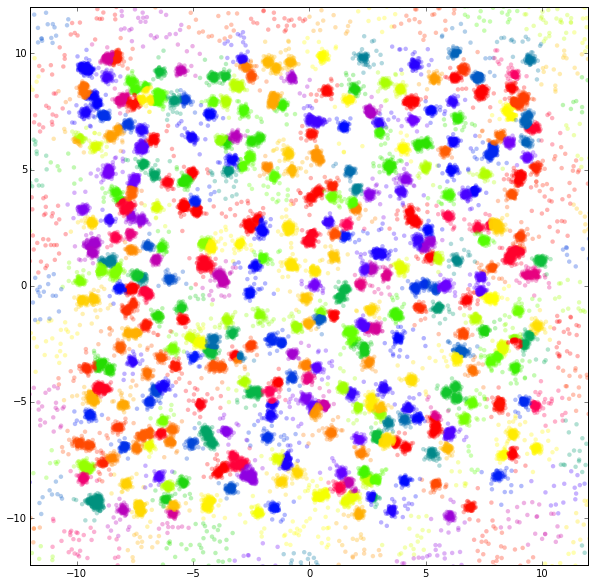

In [12]:
plot_data_with_labels(data, mbkmeans_labels)

## Birch

In [20]:
%%time
from sklearn.cluster import Birch

birch = Birch(threshold=0.5, n_clusters=600)
birch_labels = birch.fit_predict(data)

CPU times: user 6.99 s, sys: 342 ms, total: 7.34 s
Wall time: 6.97 s


In [21]:
print("NMI Birch: %0.3f"
      % normalized_mutual_info_score(labels, birch_labels))
print("ARI Birch: %0.3f"
      % adjusted_rand_score(labels, birch_labels))

NMI Birch: 0.847
ARI Birch: 0.203


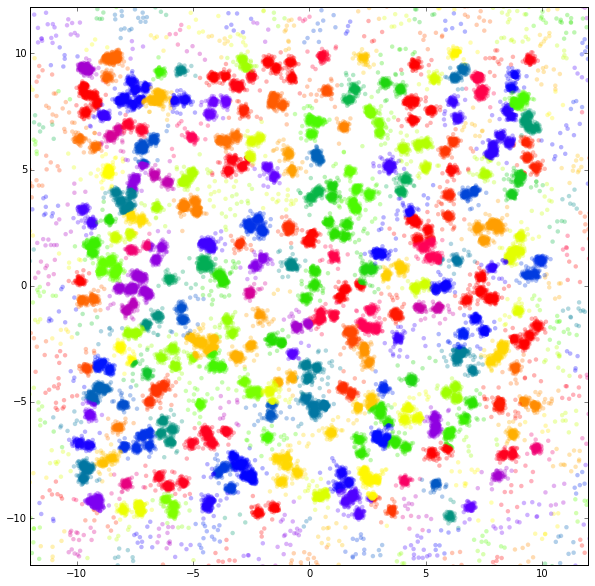

In [22]:
plot_data_with_labels(data, birch_labels)

In [23]:
print(len(birch.subcluster_centers_))

1029


In [24]:
%%time
birch.set_params(n_clusters=10)
birch.partial_fit()

CPU times: user 634 ms, sys: 10.2 ms, total: 645 ms
Wall time: 643 ms


In [25]:
%%time
birch_labels_small = birch.predict(data)

CPU times: user 1.28 s, sys: 342 ms, total: 1.62 s
Wall time: 1.3 s


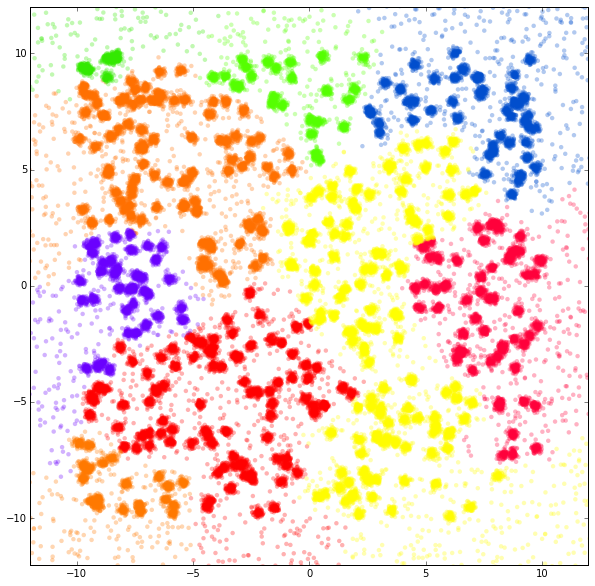

In [26]:
plot_data_with_labels(data, birch_labels_small)

## Batch K-Means

In [20]:
# %%time
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=500, n_jobs=10)
# kmeans_labels = kmeans.fit_predict(data)

In [21]:
# print("NMI K-Means: %0.3f"
#       % normalized_mutual_info_score(labels, kmeans_labels))
# print("ARI  K-Means: %0.3f"
#       % adjusted_rand_score(labels, kmeans_labels))

In [22]:
# plot_data_with_labels(data, kmeans_labels)